## End to end Deep Learning Project Using Simple RNN with PyTorch

In [1]:
# Suppress protobuf warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.19.0
PyTorch version: 2.7.1+cpu
NumPy version: 2.1.3


In [2]:
## Load the imdb dataset using TensorFlow

max_features=10000 ##vocabulary size
(X_train,y_train),(X_test,y_test)=imdb.load_data(num_words=max_features)

# Print the shape of the data
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (25000,), Training labels shape: (25000,)
Testing data shape: (25000,), Testing labels shape: (25000,)


In [3]:
X_train[0],y_train[0]

([1,
  14,
  22,
  16,
  43,
  530,
  973,
  1622,
  1385,
  65,
  458,
  4468,
  66,
  3941,
  4,
  173,
  36,
  256,
  5,
  25,
  100,
  43,
  838,
  112,
  50,
  670,
  2,
  9,
  35,
  480,
  284,
  5,
  150,
  4,
  172,
  112,
  167,
  2,
  336,
  385,
  39,
  4,
  172,
  4536,
  1111,
  17,
  546,
  38,
  13,
  447,
  4,
  192,
  50,
  16,
  6,
  147,
  2025,
  19,
  14,
  22,
  4,
  1920,
  4613,
  469,
  4,
  22,
  71,
  87,
  12,
  16,
  43,
  530,
  38,
  76,
  15,
  13,
  1247,
  4,
  22,
  17,
  515,
  17,
  12,
  16,
  626,
  18,
  2,
  5,
  62,
  386,
  12,
  8,
  316,
  8,
  106,
  5,
  4,
  2223,
  5244,
  16,
  480,
  66,
  3785,
  33,
  4,
  130,
  12,
  16,
  38,
  619,
  5,
  25,
  124,
  51,
  36,
  135,
  48,
  25,
  1415,
  33,
  6,
  22,
  12,
  215,
  28,
  77,
  52,
  5,
  14,
  407,
  16,
  82,
  2,
  8,
  4,
  107,
  117,
  5952,
  15,
  256,
  4,
  2,
  7,
  3766,
  5,
  723,
  36,
  71,
  43,
  530,
  476,
  26,
  400,
  317,
  46,
  7,
  4,
  2,
  1029,
  

In [4]:
## Inspect a sample review and its label
sample_review=X_train[0]
sample_label=y_train[0]

print(f"Sample review (as integers):{sample_review}")
print(f'Sample label: {sample_label}')


Sample review (as integers):[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Sample label: 1


In [5]:
### Mapping of words index back to words (for understanding)
word_index=imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 88584


In [6]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sample_review])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [7]:
## Pad sequences using TensorFlow's preprocessing
max_len=500

X_train=sequence.pad_sequences(X_train,maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print(f"Training data shape after padding: {X_train.shape}")
print(f"Testing data shape after padding: {X_test.shape}")

Training data shape after padding: (25000, 500)
Testing data shape after padding: (25000, 500)


In [8]:
print(f"First padded sequence: {X_train[0]}")

First padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [9]:
## Define PyTorch RNN Model
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        rnn_out, hidden = self.rnn(embedded)  # (batch_size, seq_len, hidden_dim)
        # Use the last output
        output = self.fc(rnn_out[:, -1, :])  # (batch_size, output_dim)
        output = self.sigmoid(output)
        return output

# Model parameters
vocab_size = max_features
embedding_dim = 128
hidden_dim = 128
output_dim = 1

model = SimpleRNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
print(model)

SimpleRNNClassifier(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 1313153
Trainable parameters: 1313153


In [11]:
## Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [12]:
## Convert data to PyTorch tensors and create DataLoaders
# Convert to tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create validation split
val_size = int(0.2 * len(X_train_tensor))
X_val = X_train_tensor[:val_size]
y_val = y_train_tensor[:val_size]
X_train_new = X_train_tensor[val_size:]
y_train_new = y_train_tensor[val_size:]

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_new, y_train_new)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 20000
Validation samples: 5000
Test samples: 25000


In [13]:
## Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (output.squeeze() > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.squeeze(), target)
            
            total_loss += loss.item()
            predicted = (output.squeeze() > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [14]:
## Train the model with early stopping
epochs = 6
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'simple_rnn_imdb_pytorch.pth')
        print('Model saved!')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break


Epoch 1/6


Training: 100%|██████████| 625/625 [13:06<00:00,  1.26s/it]



Train Loss: 0.6481, Train Acc: 60.93%
Val Loss: 0.5996, Val Acc: 66.92%
Model saved!

Epoch 2/6


Training: 100%|██████████| 625/625 [1:23:12<00:00,  7.99s/it]      



Train Loss: 0.5529, Train Acc: 71.75%
Val Loss: 0.5729, Val Acc: 69.74%
Model saved!

Epoch 3/6


Training: 100%|██████████| 625/625 [07:54<00:00,  1.32it/s]



Train Loss: 0.5387, Train Acc: 71.87%
Val Loss: 0.6807, Val Acc: 55.38%

Epoch 4/6


Training: 100%|██████████| 625/625 [08:37<00:00,  1.21it/s]



Train Loss: 0.6157, Train Acc: 64.75%
Val Loss: 0.6251, Val Acc: 66.84%

Epoch 5/6


Training: 100%|██████████| 625/625 [11:14<00:00,  1.08s/it]



Train Loss: 0.5287, Train Acc: 74.21%
Val Loss: 0.5701, Val Acc: 72.76%
Model saved!

Epoch 6/6


Training: 100%|██████████| 625/625 [11:21<00:00,  1.09s/it]



Train Loss: 0.4812, Train Acc: 77.67%
Val Loss: 0.5192, Val Acc: 74.56%
Model saved!


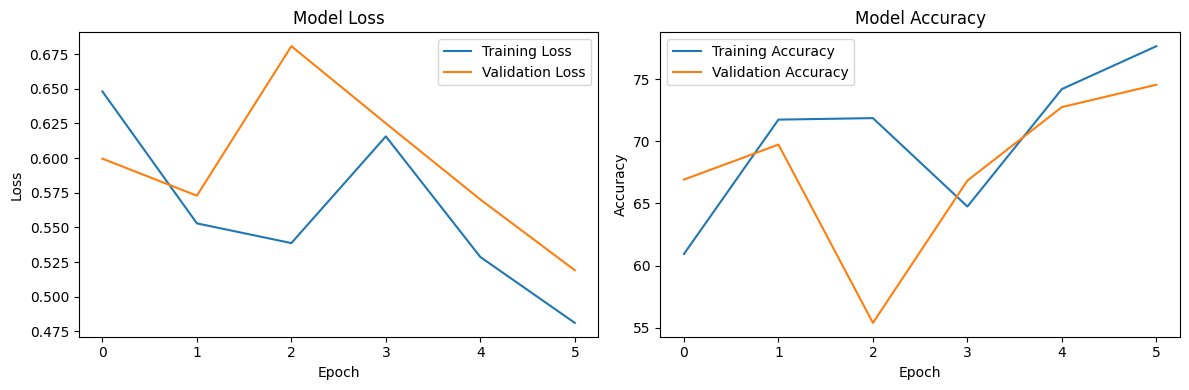

In [15]:
## Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()